## Functions to grab features from a directory

In [82]:
import os
import numpy as np

def feature_from_file(file_path, feature_type="head", byte_num=512): # will add more feature_type later
    """Retreives features from a file.
  
    Parameters:
    feature_type (str): "head" to get bytes from head of the file.
    byte_num (int): Number of bytes to grab.
    file_path (str): File path of file to get features from.
    
    Returns:
    List of bytes from file_path. 
    """
    if feature_type == "head":
        with open(file_path, 'rb') as f:
            byte = f.read(1)
            index = 1
            features = []
            
            while byte and index <= byte_num:
                features.append(byte)
                index += 1
                byte = f.read(1)
            
            if len(features) < byte_num:
                features.extend([b'' for i in range(byte_num - len(features))])
                
            assert len(features) == byte_num
            return features
    else:
        print("Invalid feature type")

def feature_from_dir(dir_path, feature_type="head", byte_num=512):
    """Takes a directory and grabs features from each file.
    
    Parameters:
    dir_path (str): Path of directory to take features from.
    feature_type (str): Type of features to get.
    byte_num (str): Number of features to take
    
    Return:
    features (list): 2D list of byte_num bytes from each fie in dir_path.
    """
    features = []
    for (dirpath, dirnames, filenames) in os.walk(dir_path):
        for filename in filenames:
            features.append(feature_from_file(os.path.join(dirpath, filename), feature_type, byte_num))
    
    return features

def translate_bytes(dir_features):
    """Translates bytes into integers.
    
    Parameter:
    dir_features (list): 2D list of bytes.
    
    Return:
    translated_features (numpy array): dir_features with bytes translated to integers.
    """
    translated_features = np.zeros((len(dir_features), len(dir_features[0])))
    
    for idx, file_features in enumerate(dir_features):
        x = np.array([int.from_bytes(c, byteorder="big") for c in file_features])
        translated_features[idx] = x
    
    return translated_features

## Feature preprocessing

In [35]:
from sklearn.model_selection import train_test_split

test_set_dir = '/Users/ryan/Documents/CS/CDAC/official_xtract/sampler_dataset/pub8'

raw_features = feature_from_dir(test_set_dir, byte_num=512)
untranslated_features = translate_bytes(raw_features)
x = untranslated_features / 255

x_train, x_test, _, _ = train_test_split(x, x)

print(raw_features[0])
print(untranslated_features[0])
print(x[0])

[b'S', b'O', b'C', b'A', b'T', b' ', b'd', b'a', b't', b'a', b' ', b'r', b'e', b'p', b'o', b'r', b't', b' ', b'c', b'r', b'e', b'a', b't', b'e', b'd', b':', b' ', b'2', b'0', b'1', b'5', b'-', b'1', b'0', b'-', b'2', b'8', b' ', b'1', b'9', b':', b'1', b'4', b' ', b'+', b'0', b'0', b'0', b'0', b'\n', b'D', b'O', b'I', b' ', b'o', b'f', b' ', b't', b'h', b'e', b' ', b'e', b'n', b't', b'i', b'r', b'e', b' ', b'S', b'O', b'C', b'A', b'T', b' ', b'c', b'o', b'l', b'l', b'e', b'c', b't', b'i', b'o', b'n', b':', b' ', b'1', b'0', b'.', b'1', b'5', b'9', b'4', b'/', b'P', b'A', b'N', b'G', b'A', b'E', b'A', b'.', b'8', b'4', b'9', b'7', b'7', b'0', b'\n', b' ', b' ', b' ', b' ', b'o', b'r', b' ', b's', b'e', b'e', b':', b' ', b'h', b't', b't', b'p', b':', b'/', b'/', b'd', b'o', b'i', b'.', b'p', b'a', b'n', b'g', b'a', b'e', b'a', b'.', b'd', b'e', b'/', b'1', b'0', b'.', b'1', b'5', b'9', b'4', b'/', b'P', b'A', b'N', b'G', b'A', b'E', b'A', b'.', b'8', b'4', b'9', b'7', b'7', b'0', b'\n', 

## Keras model

In [36]:
from keras.optimizers import SGD, Adadelta, Adam
sgd_optimizer = SGD(lr=1, decay=0.001)
adadelta_optimizer = Adadelta(lr=0.1, decay=0)
adam_optimizer = Adam(lr=0.1)

In [90]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense

input_size = len(x_train[0])

input_layer = Input((input_size,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense (64, activation='relu')(encoded)
decoded = Dense(input_size, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

history = autoencoder.fit(x_train, x_train,
                          epochs=100,
                          batch_size = 256,
                          shuffle=True,
                          validation_data=(x_test, x_test))

encoder = Model(input_layer, encoded)

print(K.eval(autoencoder.optimizer.lr))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_50 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_51 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_52 (Dense)             (None, 512)               33280     
Total params: 70,304
Trainable params: 70,304
Non-trainable params: 0
_________________________________________________________________
Train on 4791 samples, validate on 1597 samples
Epoch 1/100
4791/4791 [==============================] - 1s 185us/step - loss: -716.1343 -

In [22]:
weights = autoencoder.get_weights()
for idx, weight in enumerate(weights):
    print("LAYER {}".format(idx))
    print(weight)

LAYER 0
[[-0.05084571  0.06973114 -0.01266051 ... -0.08306095 -0.01116333
   0.00319867]
 [-0.05438119  0.03074812 -0.01937459 ... -0.0525082   0.11125287
   0.07257906]
 [-0.06934612 -0.00385563 -0.03257179 ...  0.10350678 -0.11210641
  -0.02891172]
 ...
 [ 0.07144225 -0.08722432 -0.02462004 ...  0.04178799  0.01336034
   0.03918462]
 [ 0.01879815 -0.08734938 -0.06883378 ...  0.03033322  0.12023733
   0.0033702 ]
 [-0.01016326 -0.03272462 -0.0011365  ... -0.01624553 -0.0642002
   0.07813853]]
LAYER 1
[ 0.00387681 -0.03795798 -0.05553212 -0.07462566 -0.02857636 -0.00893215
  0.15776084 -0.0478286   0.1832785   0.23961893  0.00086467  0.2561634
  0.5707312   0.24810919  0.12568723  0.01300425  0.5469935   0.0069351
  0.16038176  0.04704882  0.01310134  0.24956703  0.26172742  0.07942128
  0.02002666  0.16884068 -0.00906265 -0.07353037 -0.01124712  0.0209683
  0.49028102  0.21769533  0.11121484 -0.00531383  0.26239717 -0.07142499
  0.40984985  0.25870073  0.0601779  -0.14756127  0.519748

## Results visualization

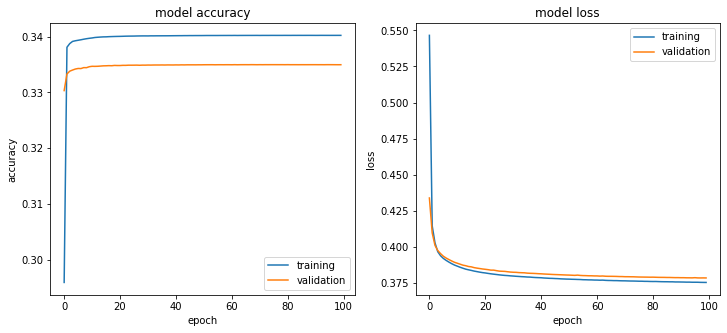

In [38]:
%%capture --no-display 
import matplotlib.pyplot as plt

# set up figure
f = plt.figure(figsize=(12,5))
f.add_subplot(1,2, 1)

# plot accuracy as a function of epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

# plot loss as a function of epoch
f.add_subplot(1,2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show(block=True)

## Feature and Label Grabbing

In [92]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import csv

le = LabelEncoder()
naivetruth_path = "/Users/ryan/Documents/CS/CDAC/official_xtract/xtract-sampler/automated_training_results/naivetruth.csv"

def grab_labels(csv_path):
    """Returns the file paths and file labels from a naivetruth csv.
    
    Parameter:
    csv_path (str): Path of csv file to take labels and paths from.
    
    Returns:
    labels (list): List of label strings from csv_path.
    file_paths (list): List of file_paths from csv_path.
    """
    labels = []
    file_paths = []
    
    with open(csv_path) as label_file:
        csv_reader = csv.reader(label_file, delimiter=',')
        for row in csv_reader:
            file_paths.append(row[0])
            labels.append(row[2])
    
    return labels, file_paths

y, file_paths = grab_labels(naivetruth_path)
y.pop(0) #Gets rid of headers
file_paths.pop(0)

x = []

for file_path in file_paths:
    x.append(feature_from_file(file_path))

x = encoder.predict(translate_bytes(x))
y = le.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y)

## File Classification

In [99]:
from keras.models import Sequential
from keras.layers import Dense, Input

classifier_dim = len(x[0])

classifier_model = Sequential()
classifier_model.add(Dense(16, activation='relu', input_shape=(classifier_dim,)))
classifier_model.add(Dense(8, activation='relu'))
classifier_model.add(Dense(5, activation='softmax'))

classifier_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
classifier_model.summary()

history = classifier_model.fit(x_train, y_train,
                               epochs=100,
                               batch_size = 256,
                               shuffle=True,
                               validation_data=(x_test, y_test)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_58 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_59 (Dense)             (None, 5)                 45        
Total params: 709
Trainable params: 709
Non-trainable params: 0
_________________________________________________________________


ValueError: Error when checking target: expected dense_59 to have shape (5,) but got array with shape (1,)